#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [396]:
import sys
sys.path.append('./../')
# !{sys.executable} -m pip install gdown h5py

In [397]:
from week_6.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

### Load the data

In [398]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [399]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
import seaborn as sns


In [400]:
display(stimulus_train.shape, spikes_train.shape)
display(stimulus_train.max(), stimulus_train.min())


(2592, 3, 224, 224)

(2592, 168)

2.64

-2.117904

In [401]:
class NA_Dataset(Dataset):
    def __init__(self, images_array, spikes_array, transform = None):
        self.images = images_array
        self.target = spikes_array
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        if self.transform:
            image = self.transform(image)
        else : 
            image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)        
        return image, target
    


In [402]:

class VanillaCNN(nn.Module):
    def __init__(self, num_channels, num_outputs, image_size=224):
        super(VanillaCNN, self).__init__()
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32 , kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Third convolution block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        reduced_size = image_size // 8 
        self.fc1 = nn.Linear(128 * reduced_size * reduced_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_outputs)
    
    def forward(self, x):
        # Convolutional block 1: conv -> bn -> ReLU -> pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Convolutional block 2: conv -> bn -> ReLU -> pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Convolutional block 3: conv -> bn -> ReLU
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [403]:
def inverse_normalisation(images):
    normalize_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    normalize_std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    inv_images = (images * normalize_std + normalize_mean) * 255.0
    return inv_images.astype(np.float32)


stimulus_train = inverse_normalisation(stimulus_train)
stimulus_val = inverse_normalisation(stimulus_val)


# display(stimulus_train.max(), stimulus_train.min(), stimulus_val.max(), stimulus_val.min())


# stm = np.transpose(stimulus_train[0], (1, 2, 0))
# stm_val = np.transpose(stimulus_val[0], (1, 2, 0))
# plt.imshow(stm.astype(np.uint8), cmap='gray')
# plt.show()
# plt.imshow(stm_val.astype(np.uint8), cmap='gray')



In [404]:
spikes_val

array([[-0.08788271, -0.01638721, -0.13403203, ...,  0.02842128,
        -0.00846578, -0.20738375],
       [ 0.02697661, -0.14471018, -0.36234146, ...,  0.5288832 ,
        -0.17825067, -0.24549925],
       [ 0.7357918 ,  0.22435175, -0.58930063, ...,  0.01999224,
         0.03580762,  0.0454006 ],
       ...,
       [-0.18341042, -0.3003577 , -0.07605718, ..., -0.17347173,
        -0.03292113, -0.2970228 ],
       [-0.01781981, -0.0523342 ,  0.8571783 , ...,  0.12983103,
         0.30777112,  0.14400192],
       [-0.30139515, -0.20936176,  0.01124607, ...,  0.07960368,
         0.34524894,  0.23937586]], dtype=float32)

In [405]:
spikes_train

array([[ 0.0153424 ,  0.16385917, -0.07326181, ..., -0.5881891 ,
        -0.1626944 , -0.70826447],
       [-0.09878279, -0.37968943, -0.2231606 , ...,  0.15873413,
         0.10990611,  0.21158436],
       [-0.10554082, -0.01188746,  0.70853746, ...,  0.5393186 ,
        -0.0743687 , -0.16959666],
       ...,
       [ 0.01140313, -0.37241054, -0.09391645, ...,  0.69843096,
         0.01658425,  0.03884423],
       [-0.5732364 , -0.5847693 , -0.13272788, ..., -0.3575872 ,
        -0.06019125,  0.31781903],
       [-0.13184752, -0.08390406, -0.09249463, ..., -0.5614103 ,
        -0.0656091 ,  0.3997365 ]], dtype=float32)

In [406]:
channel_mean = np.mean(stimulus_train / 255.0, axis=(0, 2, 3))
channel_std  = np.std(stimulus_train / 255.0, axis=(0, 2, 3))




trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean.tolist(), std=channel_std.tolist())
])




df_train = NA_Dataset(stimulus_train.transpose(0,2,3,1), spikes_train, trans)
df_val = NA_Dataset(stimulus_val.transpose(0,2,3,1), spikes_val, trans)
batch_size = 32

train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(df_val, batch_size=batch_size, shuffle=False)


device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
num_channels = 3  
image_size = stimulus_train.shape[2]
num_outputs = spikes_train.shape[1]



model = VanillaCNN(num_channels=num_channels, num_outputs=num_outputs, image_size= image_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

num_epochs = 60

for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, targets)  
        loss.backward()         
        optimizer.step()        
        
        running_train_loss += loss.item()
    average_train_loss = running_train_loss / len(train_loader)
    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
    
    average_val_loss = running_val_loss / len(val_loader)
    
    # Print loss metrics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")



Epoch [1/60], Train Loss: 0.1338, Val Loss: 0.1229
Epoch [2/60], Train Loss: 0.1073, Val Loss: 0.1095
Epoch [3/60], Train Loss: 0.0918, Val Loss: 0.1034
Epoch [4/60], Train Loss: 0.0790, Val Loss: 0.0992
Epoch [5/60], Train Loss: 0.0696, Val Loss: 0.0981
Epoch [6/60], Train Loss: 0.0638, Val Loss: 0.1021
Epoch [7/60], Train Loss: 0.0572, Val Loss: 0.0972
Epoch [8/60], Train Loss: 0.0524, Val Loss: 0.0995
Epoch [9/60], Train Loss: 0.0496, Val Loss: 0.0981
Epoch [10/60], Train Loss: 0.0460, Val Loss: 0.0970
Epoch [11/60], Train Loss: 0.0434, Val Loss: 0.0945
Epoch [12/60], Train Loss: 0.0417, Val Loss: 0.0937
Epoch [13/60], Train Loss: 0.0411, Val Loss: 0.0950
Epoch [14/60], Train Loss: 0.0398, Val Loss: 0.0995
Epoch [15/60], Train Loss: 0.0385, Val Loss: 0.0951
Epoch [16/60], Train Loss: 0.0366, Val Loss: 0.0940
Epoch [17/60], Train Loss: 0.0359, Val Loss: 0.0938
Epoch [18/60], Train Loss: 0.0342, Val Loss: 0.0946
Epoch [19/60], Train Loss: 0.0340, Val Loss: 0.0947
Epoch [20/60], Train 

Explained Variance (Model Name): 0.3221
Mean Pearson Correlation (Model Name): 0.5548


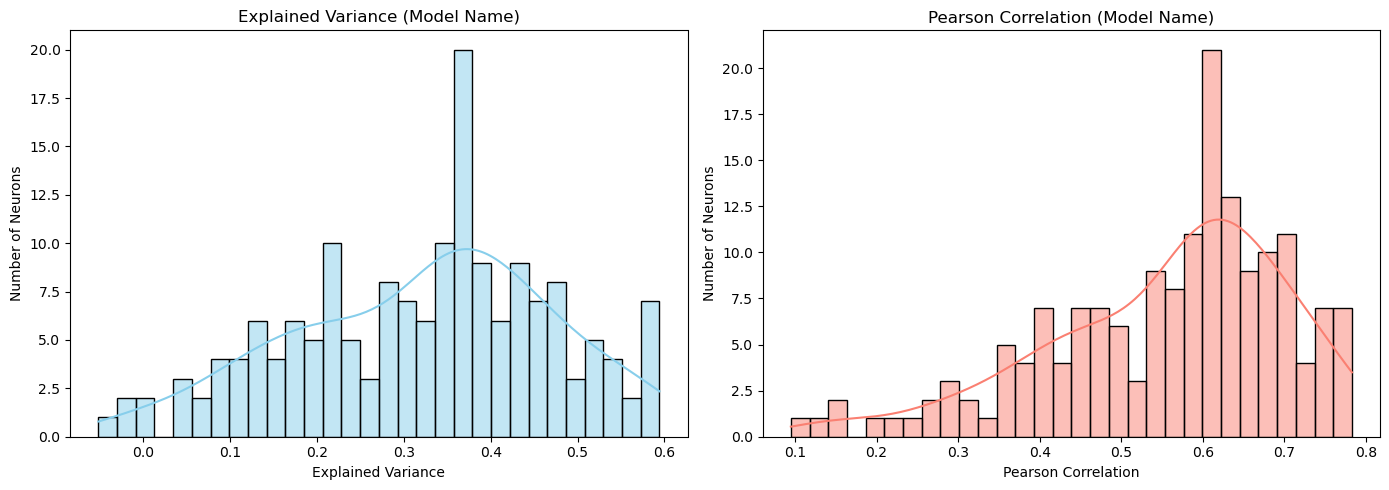

In [408]:
def compute_pearson_per_neuron(Y_true, Y_pred):
    return np.array([
        pearsonr(Y_true[:, i], Y_pred[:, i])[0] for i in range(Y_true.shape[1])
    ])

def plot_performance_metrics(Y_pred, model_name, Y_val, verbose=True):
    explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
    corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)
    if verbose:
        print(f"Explained Variance ({model_name}): {explained_var.mean():.4f}")
        print(f"Mean Pearson Correlation ({model_name}): {corr_per_neuron.mean():.4f}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(explained_var, bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Number of Neurons")

    sns.histplot(corr_per_neuron, bins=30, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(f"Pearson Correlation ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Number of Neurons")
    
    plt.tight_layout()
    plt.show()

model.eval()
all_predictions = []
all_targets = []

# Run through the validation loader and collect predictions and targets.
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_predictions.append(outputs.cpu())
        all_targets.append(targets.cpu())

# Concatenate batches.
Y_pred = torch.cat(all_predictions, dim=0).numpy()
Y_val = torch.cat(all_targets, dim=0).numpy()

explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')

plot_performance_metrics(Y_pred, "Model Name", Y_val, verbose=True)
